In [12]:
import pandas as pd
import numpy as np
from sklearn.utils.extmath import randomized_svd
import seaborn as sns
import matplotlib.pyplot as plt

# 단계 1: 데이터 로드

데이터 불러오기: pandas 라이브러리를 사용하여 ratings.csv와 movies.csv를 로드합니다.
- ratings.csv는 ratings 변수 안에 넣어주세요
- movies.csv는 movies 변수 안에 넣어주세요

In [13]:
ratings = pd.read_csv('./data/raw/ml-latest-small/ratings.csv')
print(ratings.head())

movies = pd.read_csv('./data/raw/ml-latest-small/movies.csv')
print(movies.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


##ratings.csv 파일 변수 설명:
userId: 각 사용자를 고유하게 식별하는 ID입니다.

movieId: 각 영화를 고유하게 식별하는 ID입니다.

rating: 사용자가 특정 영화에 부여한 평점 (0.5 ~ 5.0).

timestamp: 평점이 기록된 시간
##movies.csv 파일 변수 설명:
movieId: 각 영화를 고유하게 식별하는 ID입니다.

title: 영화의 제목과 개봉 연도.

genres: 영화의 장르 (예: Action|Adventure|Sci-Fi). 여러 장르는 '|'로 구분됩니다.

# 단계 2: 시스템 학습에 적합한 행렬 형태로 변환

## 하는 일:
누가 어떤 영화에 몇 점을 줬는지 표(Matrix)로 정리하기

## 왜 하나요? (데이터의 구조화):
데이터가 여기저기 흩어져 있으면 컴퓨터가 패턴을 읽기 어렵습니다. 마치 도서관 대출 장부를 한눈에 볼 수 있는 '출석부' 형태로 만드는 과정입니다.

## 비유:
"거대한 바둑판 만들기" 가로줄은 학생 이름, 세로줄은 책 제목인 커다란 바둑판을 그린다고 생각해보세요. \
읽은 책에는 점수를 적고, 안 읽은 책은 빈칸으로 둡니다. 이 바둑판이 있어야 "어라? 철수랑 영희랑 읽은 책이 비슷하네?"라는 비교가 가능해집니다.


## 요구사항 :

행렬 변환: * userId를 행(index)으로, movieId를 열(column)로, rating을 값(value)으로 하는 평점 행렬을 생성합니다.

사용자가 평가하지 않은 빈칸(NaN)은 모두 0으로 채워야 합니다.

사용 메소드: pivot, fillna(0) 등을 활용합니다.

행렬 변수 명 : df_user_movie_matrix

In [14]:
df_user_movie_matrix = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)
matrix = df_user_movie_matrix.values
print(matrix)
print(df_user_movie_matrix.shape)
print(df_user_movie_matrix.head())

[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]
(610, 9724)
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...  

# 단계 3: 평점 정규화 (Bias 제거)
## 하는 일:
각 사용자의 평균 점수를 구해서, 개별 평점에서 그 평균을 빼기

## 왜 하나요? (기준의 통일):
어떤 사람은 성격이 후해서 다 5점을 주고, 어떤 사람은 깐깐해서 최고점이 3점일 수 있습니다. 이 '개인적 기준'을 제거해야 그 사람이 진짜로 어떤 영화를 상대적으로 더 좋아하는지 알 수 있습니다.

## 비유:
"심사위원의 점수 주관성 제거" 노래 경연 대회에서 A 심사위원은 점수를 짜게 주고 B 심사위원은 후하게 준다면, 점수만 봐서는 누가 더 잘했는지 알 수 없죠? 그래서 각 심사위원이 평소 주는 평균 점수를 뺌으로써, "평소보다 얼마나 더 감동했나?"라는 '진심'만 남기는 작업입니다.

## 요구사항:
1. 원본 데이터를 보호하기 위해 똑같은 복사본을 만듭니다. (복사본 이름: matrix_with_nan)
2. 평점 데이터에서 0점인 부분을 '값이 없음(NaN)'으로 바꿉니다.
3. NaN을 제외하고, 실제로 점수가 있는 것들만 골라서 사용자별 평균을 내라(axis=1)는 뜻입니다.
4. 혹시라도 영화를 한 편도 안 봐서 평균을 구할 수 없는 사용자(NaN 발생)가 있다면, 그 결과값을 다시 0으로 안전하게 바꿔줍니다.

In [15]:
# 1) 원본 보호: 복사본 만들기
matrix_with_nan = df_user_movie_matrix.copy()

# 2) 0점(미평가)을 NaN으로 바꾸기
matrix_with_nan[matrix_with_nan == 0] = np.nan

# 3) NaN 제외하고 사용자별 평균(행 기준 axis=1) 계산
user_mean = matrix_with_nan.mean(axis=1)
# user_mean = np.nanmean(matrix_with_nan, axis=1)

# 4) 평점이 하나도 없는 사용자면 평균이 NaN -> 0으로 안전 처리
user_mean = user_mean.fillna(0)
# user_mean = np.nan_to_num(user_mean)

print(user_mean.head())

# 정규화된 행렬 만들기: (평점 - 사용자 평균)
df_user_movie_normalized = matrix_with_nan.sub(user_mean, axis=0)

# 원래 미평가(NaN)였던 곳은 0으로 복원
df_user_movie_normalized = df_user_movie_normalized.fillna(0)

userId
1    4.366379
2    3.948276
3    2.435897
4    3.555556
5    3.636364
dtype: float64


# 단계 4: SVD를 이용한 차원 축소 및 핵심 잠재 요인 추출

## 하는 일:
거대한 바둑판(행렬)을 핵심 특징 50개로 압축하기

## 왜 하나요? (핵심 특징 파악):
영화 수만 권을 다 분석하기엔 너무 복잡합니다. 대신 '액션성', '감동', '긴장감' 같은 핵심 키워드(잠재 요인)로 요약하면 데이터는 작아지면서도 본질은 유지됩니다.

## 요구 사항:
복잡한 데이터를 핵심적인 취향 테마로 압축하는 과정입니다.\
모델 라이브러리: scikit-learn의 randomized_svd를 사용하여 대규모 연산에 최적화된 방식으로 행렬을 분해합니다.\
하이퍼파라미터 설정:
1. 핵심 패턴인 잠재 요인(Latent Factors)의 개수(n_components)를 50으로 설정합니다.
2. 조정 횟수(n_iter)를 5로 설정합니다.

행렬 분해: 정규화된 행렬을 U, s, VT 세 개의 행렬로 분해합니다.

In [16]:
# 정규화된 평점 행렬 (user x movie)
R = df_user_movie_normalized.values  # shape: (n_users, n_movies)

# SVD 분해: R ≈ U @ diag(s) @ VT
U, s, VT = randomized_svd(
    R,
    n_components=50,
    n_iter=5,
    random_state=42
)

print("U shape :", U.shape)    # (n_users, 50)
print("s shape :", s.shape)    # (50,)
print("VT shape:", VT.shape)   # (50, n_movies)

U shape : (610, 50)
s shape : (50,)
VT shape: (50, 9724)


# 단계 5: 차원축소 데이터로 원본 행렬 근사 복원
## 하는 일:
- SVD(특이값 분해)를 통해 찾아낸 '핵심 취향' 데이터를 바탕으로, 아직 보지 않은 영화의 점수를 채워넣어 전체 판을 다시 짜는 과정입니다.
- 분해했던 재료들을 다시 조립하여 미래를 예측하는 아주 마법 같은 단계입니다.

## 요구사항:
1. 압축된 핵심 정보를 다시 펼치기
  - 의미: SVD 결과로 나온 s는 영화 데이터에서 추출한 '핵심 특징(장르, 배우 등)'들이 얼마나 중요한지 담긴 리스트입니다. 이를 행렬 계산이 가능하도록 대각선 방향으로 펼친 행렬(대각행렬)로 만듭니다.
2. 부서진 조각 맞추기
  - 분해되었던 세 가지 요소($U, S, VT$)를 다시 곱합니다. 이렇게 하면 0(빈칸)이 가득했던 처음의 행렬이, 예측값으로 꽉 찬 새로운 행렬로 탄생합니다.
3. 개인 취향 더하기
  - 아까 단계 3에서 뺐던 '사용자별 평균 점수'를 다시 더해줍니다.
4. DataFrame으로 표로 정리하기


In [52]:
# 1) 압축된 핵심 정보를 다시 펼치기: s -> 대각행렬 S
S = np.diag(s)  # (50, 50)

# 2) 부서진 조각 맞추기: U @ S @ VT 로 근사 복원 (정규화 스케일에서의 예측치)
R_hat_normalized = U @ S @ VT  # (n_users, n_movies)

# 3) 사용자별 평균 점수(단계3에서 뺐던 것) 다시 더하기
# user_mean: index가 userId인 Series
R_hat = R_hat_normalized + user_mean.values.reshape(-1, 1)

# 4) DataFrame으로 표로 정리하기 (원래 userId/ movieId 인덱스 유지)
df_pred_ratings = pd.DataFrame(
    R_hat,
    index=df_user_movie_matrix.index,
    columns=df_user_movie_matrix.columns
)

# df_pred_ratings = df_pred_ratings.clip(lower=0.5, upper=5.0)

print(df_pred_ratings.shape)
print(df_pred_ratings.head())

(610, 9724)
movieId    1         2         3         4         5         6         7       \
userId                                                                          
1        4.352589  4.277628  4.338038  4.354390  4.341245  4.075129  4.182902   
2        3.936643  3.936795  3.942364  3.952944  3.955821  3.937100  3.927488   
3        2.439763  2.463286  2.389917  2.445750  2.461446  2.403453  2.453444   
4        3.498435  3.632830  3.514086  3.490894  3.506224  3.591726  3.585116   
5        3.813666  3.616240  3.629705  3.616007  3.603547  3.745175  3.617735   

movieId    8         9         10      ...    193565    193567    193571  \
userId                                 ...                                 
1        4.352091  4.383275  4.227027  ...  4.366369  4.366343  4.366394   
2        3.951571  3.952765  3.979641  ...  3.948219  3.948079  3.948358   
3        2.457896  2.427255  2.449779  ...  2.435857  2.435759  2.435955   
4        3.511527  3.546550  3.466259  .

# 단계 6: 추천 알고리즘 구현 및 검증
특정 사용자를 대상으로 실제 추천 기능을 수행하는 함수를 제작합니다.

## 요구사항

이력 관리: \
특정 사용자가 과거에 높은 평점(예: 5.0)을 주었던 영화 목록을 먼저 확인합니다.

추천 생성: \
관람하지 않은 영화들 중 단계 4에서 계산된 예측 평점이 가장 높은 상위 5개 영화를 제목 및 장르와 함께 출력합니다.

In [32]:
def show_user_history(user_id: int, ratings: pd.DataFrame, movies: pd.DataFrame, high_rating: float = 5.0):
    """
    특정 사용자가 과거에 높은 평점(high_rating)을 준 영화 목록 출력
    """
    user_high = ratings[(ratings["userId"] == user_id) & (ratings["rating"] >= high_rating)].copy()
    user_high = user_high.merge(movies, on="movieId", how="left")
    # user_high = user_high.sort_values(["rating", "timestamp"], ascending=[False, False])
    user_high = user_high.sort_values("rating", ascending=False)

    cols = ["movieId", "rating", "title", "genres"]
    return user_high[cols]


def recommend_top_n(user_id: int,
                    df_pred_ratings: pd.DataFrame,
                    df_user_movie_matrix: pd.DataFrame,
                    movies: pd.DataFrame,
                    n: int = 5):
    """
    특정 사용자에게:
    - 이미 본 영화 제외
    - 예측 평점이 높은 Top-N 추천 (title, genres 포함)
    """
    # 1) 사용자가 이미 평가한(본) 영화: 원본 평점행렬에서 0이 아닌 컬럼
    seen_movie_ids = df_user_movie_matrix.loc[user_id]
    seen_movie_ids = seen_movie_ids[seen_movie_ids > 0].index

    # 2) 예측 평점 중 안 본 영화만 남기기
    user_pred = df_pred_ratings.loc[user_id].drop(index=seen_movie_ids)

    # 3) 예측 평점 상위 N개 뽑기
    top_movie_ids = user_pred.sort_values(ascending=False).head(n).index

    # 4) movies 메타데이터와 결합해서 출력 형태 만들기
    recs = movies[movies["movieId"].isin(top_movie_ids)].copy()
    recs = recs.set_index("movieId").loc[top_movie_ids].reset_index()  # 예측점수 순서 유지

    recs["pred_rating"] = user_pred.loc[top_movie_ids].values
    recs = recs[["movieId", "pred_rating", "title", "genres"]]

    return recs

def get_recs(user_id, n_recs=5):
    user_data = ratings[ratings.userId == user_id]
    user_hist = user_data.merge(movies, on='movieId').sort_values(['rating'], ascending=False)

    user_pred = df_pred_ratings.loc[user_id]
    recs = movies[-movies['movieId'].isin(user_hist['movieId'])].copy()
    recs['est_rating'] = recs['movieId'].map(user_pred)

    return user_hist.head(n_recs), recs.sort_values('est_rating', ascending=False).head(n_recs)

history, recommendations = get_recs(user_id=33)
display(history)
display(recommendations)

,userId,movieId,rating,timestamp,title,genres
9,33,36,5.0,939715317,Dead Man Walking (1995),Crime|Drama
10,33,39,5.0,939654896,Clueless (1995),Comedy|Romance
6,33,28,5.0,939654815,Persuasion (1995),Drama|Romance
12,33,50,5.0,939646733,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
15,33,110,5.0,939648134,Braveheart (1995),Action|Drama|War


,movieId,title,genres,est_rating
322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,4.135534
659,858,"Godfather, The (1972)",Crime|Drama,4.104737
706,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,4.096422
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,4.090614
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.078812


In [33]:
user_id = 33

# 1) 이력 관리: 5점 준 영화 보기
history_5 = show_user_history(user_id, ratings, movies, high_rating=5.0)
print("== 과거 5.0 준 영화 목록 ==")
display(history_5.head(20))

# 2) 추천 생성: 안 본 영화 중 예측 평점 Top5
recs = recommend_top_n(user_id, df_pred_ratings, df_user_movie_matrix, movies, n=5)
print("\n== 추천 Top 5 ==")
display(recs)

== 과거 5.0 준 영화 목록 ==


,movieId,rating,title,genres
0,28,5.0,Persuasion (1995),Drama|Romance
1,36,5.0,Dead Man Walking (1995),Crime|Drama
2,39,5.0,Clueless (1995),Comedy|Romance
3,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
4,110,5.0,Braveheart (1995),Action|Drama|War
5,265,5.0,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance
6,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
7,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
8,337,5.0,What's Eating Gilbert Grape (1993),Drama
9,339,5.0,While You Were Sleeping (1995),Comedy|Romance



== 추천 Top 5 ==


,movieId,pred_rating,title,genres
0,364,4.135534,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
1,858,4.104737,"Godfather, The (1972)",Crime|Drama
2,924,4.096422,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
3,47,4.090614,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,2959,4.078812,Fight Club (1999),Action|Crime|Drama|Thriller


# 단계 7: 시각화
## 요구사항
1. 원본 행렬(Sparse)과 복원 행렬(Full)의 차이를 seaborn.heatmap으로 시각화하여 데이터가 채워지는 과정을 증명한다.
2. Scree Plot를 사용하여 전체 데이터 중 각 잠재 요인(Latent Factor)이 차지하는 정보량의 강도를 나타낸다.
3. Distribution Plot를 사용하여 실제 평점의 분포와 모델이 예측한 평점의 분포를 비교하여 모델의 안정성을 확인한다.

In [41]:
# 보기 좋게 일부만 샘플 (유저 30명, 영화 50개)
# n_users = min(50, df_user_movie_matrix.shape[0])
# n_movies = min(50, df_user_movie_matrix.shape[1])
n_users = ratings.groupby('userId')['rating'].count().sort_values(ascending=False).index[:50]
n_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).index[:50]

# user_sample = df_user_movie_matrix.index[:n_users]
# movie_sample = df_user_movie_matrix.columns[:n_movies]
# orig_sub = df_user_movie_matrix.loc[user_sample, movie_sample]
# pred_sub = df_pred_ratings.loc[user_sample, movie_sample]

u_idx = [df_user_movie_matrix.index.get_loc(u) for u in n_users]
m_idx = [df_user_movie_matrix.columns.get_loc(m) for m in n_movies]

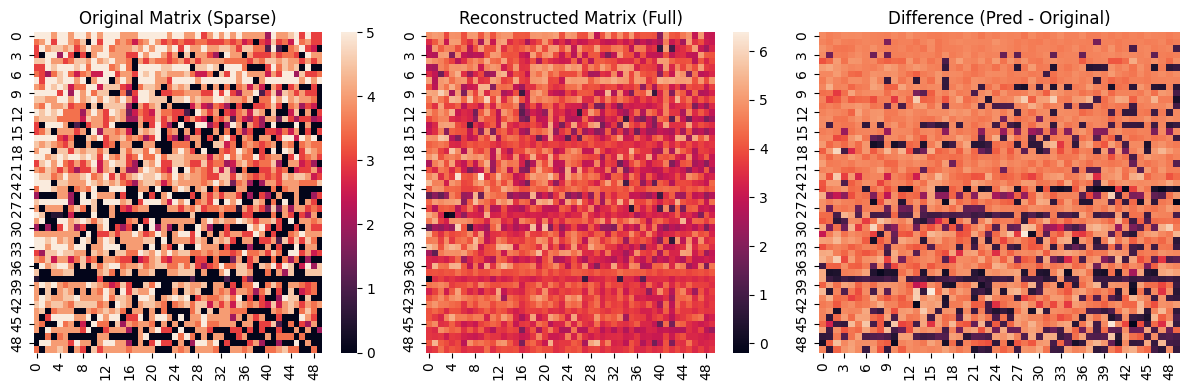

In [48]:
diff_sub = matrix[np.ix_(u_idx, m_idx)] - R_hat[np.ix_(u_idx, m_idx)]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.heatmap(matrix[np.ix_(u_idx, m_idx)], cbar=True)
plt.title("Original Matrix (Sparse)")

plt.subplot(1, 3, 2)
sns.heatmap(R_hat[np.ix_(u_idx, m_idx)], cbar=True)
plt.title("Reconstructed Matrix (Full)")

plt.subplot(1, 3, 3)
sns.heatmap(diff_sub, cbar=False)
plt.title("Difference (Pred - Original)")

plt.tight_layout()
plt.show()

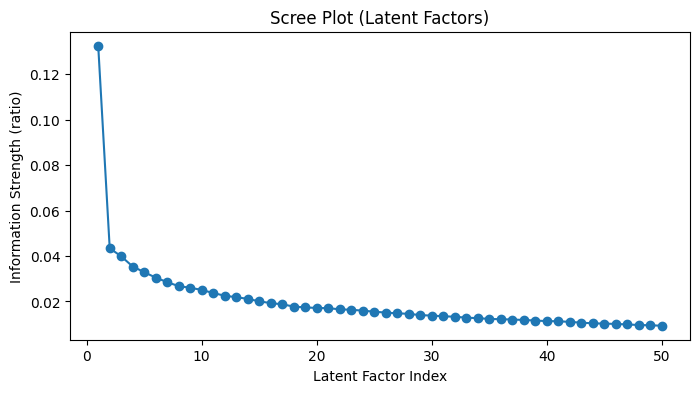

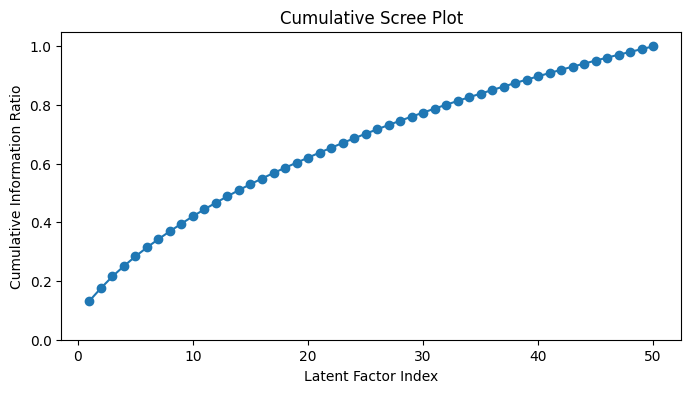

In [22]:
# 정보량(기여도) 비율: s^2 기반
info = s**2
info_ratio = info / info.sum()
cum_info_ratio = np.cumsum(info_ratio)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(info_ratio)+1), info_ratio, marker='o')
plt.xlabel("Latent Factor Index")
plt.ylabel("Information Strength (ratio)")
plt.title("Scree Plot (Latent Factors)")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_info_ratio)+1), cum_info_ratio, marker='o')
plt.xlabel("Latent Factor Index")
plt.ylabel("Cumulative Information Ratio")
plt.title("Cumulative Scree Plot")
plt.ylim(0, 1.05)
plt.show()

In [53]:
# 실제 평점이 있는 (userId, movieId) 위치의 예측값을 가져오기
pred_on_observed = ratings.apply(
    lambda row: df_pred_ratings.loc[row["userId"], row["movieId"]],
    axis=1
)

actual = ratings["rating"].astype(float)
pred = pred_on_observed.astype(float)

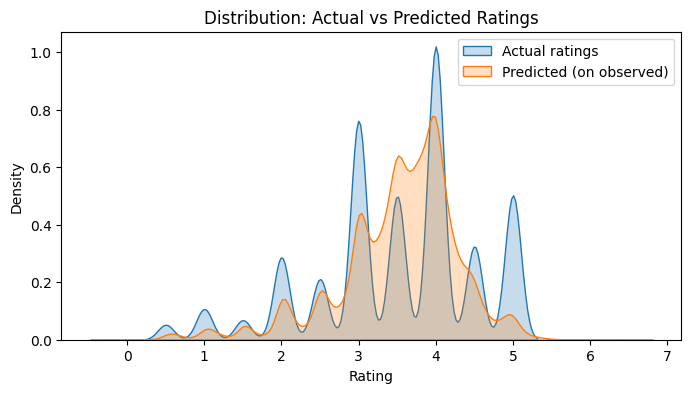

In [59]:
plt.figure(figsize=(8, 4))
sns.kdeplot(actual, label="Actual ratings", fill=True)
sns.kdeplot(pred, label="Predicted (on observed)", fill=True)
plt.title("Distribution: Actual vs Predicted Ratings")
plt.xlabel("Rating")
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(actual, pred, squared=False)
print("RMSE (on observed ratings):", rmse)

TypeError: got an unexpected keyword argument 'squared'